In [1]:
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from pathlib import Path
import torch
from common_tools import plt_show
import cv2
import numpy as np
import supervision as sv
import splitfolders

In [2]:
GROUNDING_DINO_CONFIG_PATH = Path("../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = Path("../weights/groundingdino_swint_ogc.pth")
SAM_CHECKPOINT_PATH = Path("../weights/sam_vit_h_4b8939.pth")
SAM_B_CHECKPOINT_PATH = Path("../weights/sam_vit_b_01ec64.pth")

In [4]:
dataset_path = Path("../dataset/Pallets")

In [5]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

# On single Image

In [11]:
ds_img_path_list = list(dataset_path.iterdir())
test_image = cv2.imread(ds_img_path_list[10])

## Zero-shot object detection with Grounding DINO

In [12]:
grounding_dino_model = Model(
    model_config_path= GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH
)

final text_encoder_type: bert-base-uncased


In [13]:
detections = grounding_dino_model.predict_with_classes(
    image= test_image,
    classes= ["pallets", "ground"],
    box_threshold= 0.35,
    text_threshold= 0.25
)

## Prompting SAM with detected boxes

In [ ]:
# sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT_PATH).to(
#     device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# )
# sam_predictor = SamPredictor(sam)

In [15]:
sam_b = sam_model_registry["vit_b"](checkpoint=SAM_B_CHECKPOINT_PATH).to(
    device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
sam_predictor = SamPredictor(sam_b)

In [17]:
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

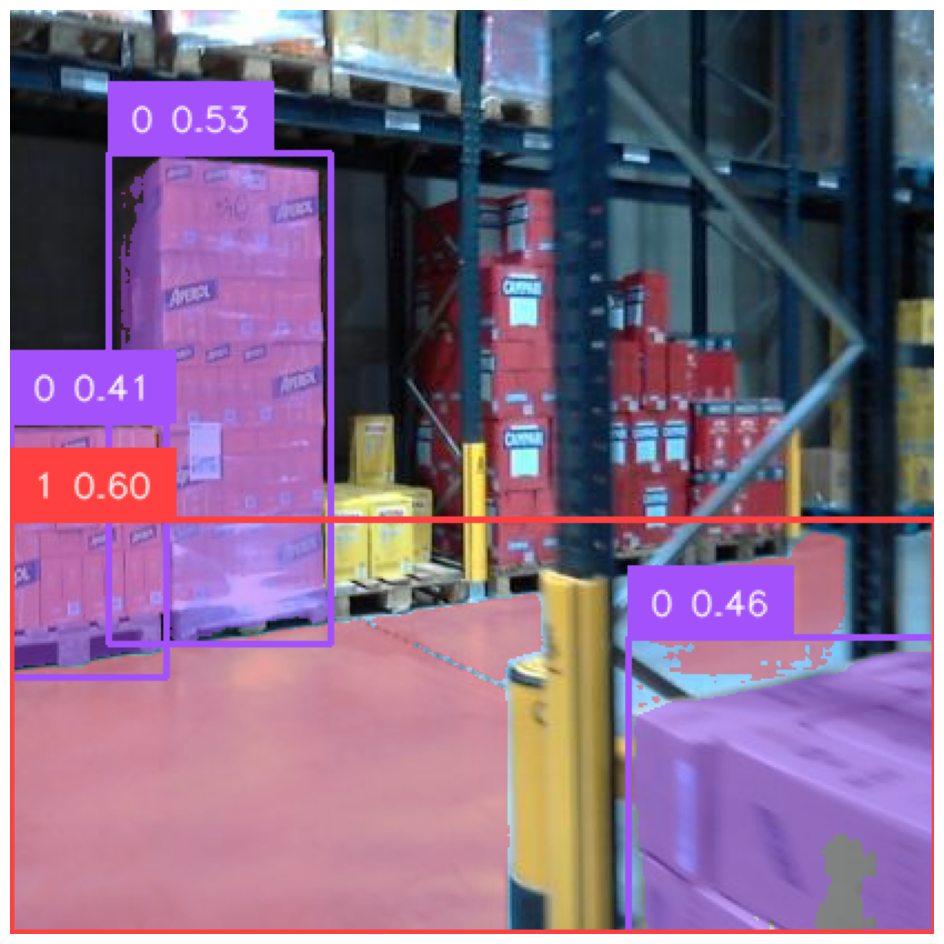

In [18]:
box_annotator = sv.BoxAnnotator()
mask_anotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_frame = mask_anotator.annotate(
    scene=test_image.copy(),
    detections=detections
)
annotated_frame = box_annotator.annotate(
    scene= annotated_frame,
    detections=detections
)
annotated_frame = label_annotator.annotate(
    scene= annotated_frame,
    detections=detections,
    labels=[f"{class_id} {confidence:0.2f}" for _, _, confidence, class_id, _,_ in detections]
)
sv.plot_image(annotated_frame)

# Full Dataset

In [6]:
images = {}
annotations = {}

In [7]:
grounding_dino_model = Model(
    model_config_path= GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH
)

sam_b = sam_model_registry["vit_b"](checkpoint=SAM_B_CHECKPOINT_PATH).to(
    device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
sam_predictor = SamPredictor(sam_b)

final text_encoder_type: bert-base-uncased


In [8]:
for img_path in dataset_path.iterdir():
    image = cv2.imread(
        str(img_path)
    )

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes= ["pallets", "ground"],
        box_threshold= 0.35,
        text_threshold= 0.25,
    )
    detections = detections[detections.class_id != None ]
    detections.mask = segment(
        sam_predictor= sam_predictor,
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    print(img_path.name)
    images[str(img_path)] = image
    annotations[str(img_path)] = detections

832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47.jpg
1564564238-002053_jpg.rf.38520dc1500faf9d2e5372529d44fd38.jpg
1574675093260-35_jpg.rf.a446631a556fafcf50666e85611042ac.jpg
2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8.jpg
1564563112-631914_jpg.rf.64fcfaf72c719265713e51f1ecc0d82f.jpg
1574674988-8533869_jpg.rf.5f80ede609debc4f29d0a112125bc61f.jpg
1564564911809-95_jpg.rf.adc540423f21cee4f83a6c80f51d7d7e.jpg
1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a.jpg
1576593221-8680673_jpg.rf.d74ec7cb87ed8c1b164e66f0ee37644c.jpg
1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd.jpg
1579165146-19246_jpg.rf.e1ed4b6a6608ad5585290b254a35e83c.jpg
1576593141-0099733_jpg.rf.26abca1de91c137f53380ec346ca9c28.jpg
513095553-9437_jpg.rf.4982628a31d48154099ba9ec3c74e148.jpg
512139289-8439_jpg.rf.3968332c33f175b1703ddaf84521e093.jpg
1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078.jpg
1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541.jpg
1583416216-4489245_jpg.

In [14]:
from supervision.dataset.core import ClassificationDataset, DetectionDataset, load_yolo_annotations, Detections
from supervision.dataset.formats.yolo import detections_to_yolo_annotations

In [30]:
images['../dataset/Pallets/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg'].shape

(416, 416, 3)

In [10]:
detections_to_yolo_annotations( annotations['../dataset/Pallets/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg'],
                              image_shape=images['../dataset/Pallets/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg'].shape)

['1 0.00000 0.77644 0.00000 0.99760 0.99760 0.99760 0.99760 0.95673 0.98077 0.95913 0.98558 0.96394 0.98317 0.96875 0.97596 0.96394 0.97596 0.95913 0.96635 0.96394 0.94712 0.95673 0.91827 0.93269 0.90144 0.91106 0.84615 0.86779 0.82692 0.86298 0.80769 0.84856 0.79327 0.83413 0.79087 0.82692 0.73317 0.78846 0.72837 0.77644 0.70913 0.76442 0.70433 0.75000 0.70673 0.74760 0.70433 0.74279 0.70433 0.71875 0.70673 0.71635 0.70433 0.68750 0.60817 0.68750 0.57452 0.66106 0.55769 0.65385 0.54567 0.64183 0.53846 0.63942 0.52404 0.62019 0.49038 0.60096 0.47356 0.58413 0.43990 0.56010 0.37500 0.56010 0.37260 0.55769 0.32933 0.56010 0.32212 0.58173 0.32452 0.62740 0.31971 0.64183 0.31010 0.64904 0.25721 0.71394 0.23317 0.73798 0.18750 0.77163 0.11538 0.76923 0.09615 0.77644 0.05288 0.77644 0.05048 0.77404 0.00240 0.77404',
 '0 0.00481 0.15625 0.00000 0.15865 0.00000 0.73558 0.01202 0.74038 0.02404 0.73317 0.04327 0.73317 0.05529 0.74519 0.05769 0.76923 0.07452 0.77163 0.11298 0.76202 0.11298 0.7476

In [15]:
dataset = DetectionDataset(
    classes= ["pallets", "ground"],
    images=images,
    annotations=annotations
)

SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


In [18]:
train_val_set, test_set = dataset.split(
    split_ratio=0.9,
    random_state= 42,
    shuffle=True
)

SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.
SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


In [21]:
train_set, val_set = train_val_set.split(
    split_ratio=0.89,
    random_state=43,
    shuffle=True
)

SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.
SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


In [27]:
train_set.as_yolo(
    images_directory_path= dataset_path.parent / "yolo_dataset" /"train",
    annotations_directory_path= dataset_path.parent / "yolo_dataset" / "train"
)
test_set.as_yolo(
    images_directory_path = dataset_path.parent / "yolo_dataset" / "test",
    annotations_directory_path = dataset_path.parent / "yolo_dataset" / "test",
)
val_set.as_yolo(
    images_directory_path = dataset_path.parent / "yolo_dataset" / "val",
    annotations_directory_path = dataset_path.parent / "yolo_dataset" / "val"
)

In [28]:
test_set.classes

['pallets', 'ground']